In [54]:
import numpy as np
import pandas as pd
import seaborn as sns

from tools_YeTao import *

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import category_encoders as ce
from sklearn.base import BaseEstimator
from sklearn.compose import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import *
from sklearn.decomposition import PCA



from sklearn.impute import *
from sklearn.inspection import permutation_importance
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *



import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

# Read in dataset

In [2]:
raw = pd.read_csv("./data/IncomePredictionTrain.txt")
raw.head()

,rowid,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_income
0,1,38,Private,108907,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,?,<=50K
1,3,58,Self-emp-not-inc,33309,HS-grad,9,Widowed,Farming-fishing,Not-in-family,White,Male,0,0,80,United-States,<=50K
2,4,62,Private,169204,HS-grad,9,Widowed,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K
3,5,53,Private,82646,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,55,United-States,>50K
4,6,40,Local-gov,233891,HS-grad,9,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,35,United-States,<=50K


# Section 1: Exploratory Analysis

Pretty clean dataset without missing but there're '?' inside the data so my guess is missing values are filled with question mark one way we can do is to remove all the row with "?" but I decided not do that since missing value might have some useful information, I will simple treat "?" as an extra category

In [3]:
raw.isna().sum(axis=0)

rowid             0
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
yearly_income     0
dtype: int64

In [4]:
col_names, num_data = raw.columns, raw.shape[0]
for c in col_names:
    num_non = raw[c].isin(["?"]).sum()
    if num_non > 0: print ("Feature", c, "has" , num_non, "rows with missing values")

Feature workclass has 1465 rows with missing values
Feature occupation has 1471 rows with missing values
Feature native_country has 486 rows with missing values


## (A) Inital Insights

1. Since there're 2 categories for target variable (yearly income) in the dataset, we're dealing with the binary classification problem, and potential metrics could be accuracy, precision recall, F1 score
Before that, we need to further check the distribution of these two categories to see if the imbalance issue excsits
More exploratoy analysis will be done below

2. In addition we also need to differeniate the numerical features and categorical features, and convert the categorical data from object to category type


4. When building model, we will choose to use cross validation, since dataset is imbalanced we need to use stratified sampling from sklearn
<br>


###  Identifying categorical variables


- Some of the features (columns) is clearly a categorical variable. eg. [worlclass, education, marital_status, occupation, relationship, race, sex, native_country]


<br>

###  Identifying numerical variables


- age, fnlwgt, education_num, capital_gain, capital_loss,hours_per_week, yearly_income


<br>


- when we have categorical data before feeding into the model we have to encode all of those categorical data, some potential methods: one hot encoding, label encoding, beta encding ... And we also need to encode the dependant variable yearly_income in to [0, 1] as well



<br>


## (B) Help to choose the appropriate machine learning method(s)

- I think I am required to use KNN for this tasks (hyperparamter tuninh later). But other potential models could be logistic regression, support vector machine, and random forest.


<br>


## (C) Suggest issues in the data that may need to be addressed prior to modeling

- Since we are only use KNN classfier, one thing we should be careful is that when encoding the categorical data, we should avoid one hot encoding since it will cause curse of dimentionality issue especailly with high cardinality. For machine learning model based on Euclidean distance like KNN, high dimentionality will cause the model assumption failes.

- So here I also choose to use hash encoder basically Hashing the high dimensional input vectors into a lower dimensional feature space. The hashing-trick preserves sparsity and approximately preserves the Euclidean norm. It is often use for representing text but it can also be used for in settings with a large number of categories. On disadvantage is that there might be collision issue with it. 

- Interesting thing is that I tried one-hot encoder as well as hashing while one-hot encoder foe some reasons has 2% increase in f1 score. So in the end, I choose to stick with one-hot encoder

In [5]:
# convert to category data

cat_features = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "yearly_income"]
num_features = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss","hours_per_week"]

raw['yearly_income_num']= raw['yearly_income'].map({'<=50K': 0, '>50K': 1})
data = convert_to_cat(cat_features, raw) # convert object data type to category

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   rowid              26049 non-null  int64   
 1   age                26049 non-null  int64   
 2   workclass          26049 non-null  category
 3   fnlwgt             26049 non-null  int64   
 4   education          26049 non-null  category
 5   education_num      26049 non-null  int64   
 6   marital_status     26049 non-null  category
 7   occupation         26049 non-null  category
 8   relationship       26049 non-null  category
 9   race               26049 non-null  category
 10  sex                26049 non-null  category
 11  capital_gain       26049 non-null  int64   
 12  capital_loss       26049 non-null  int64   
 13  hours_per_week     26049 non-null  int64   
 14  native_country     26049 non-null  category
 15  yearly_income      26049 non-null  category
 16  year

In [7]:
data.head(3)

,rowid,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_income,yearly_income_num
0,1,38,Private,108907,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,?,<=50K,0
1,3,58,Self-emp-not-inc,33309,HS-grad,9,Widowed,Farming-fishing,Not-in-family,White,Male,0,0,80,United-States,<=50K,0
2,4,62,Private,169204,HS-grad,9,Widowed,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K,0


As we can see down below, the frequence of yearly income wage <= 50k are way more that the frequency than wage > 50k. And this makes sense since majority of people are not rich, and it turns out that this is an imbalanced data set so we need to take care of it with stratified sampling

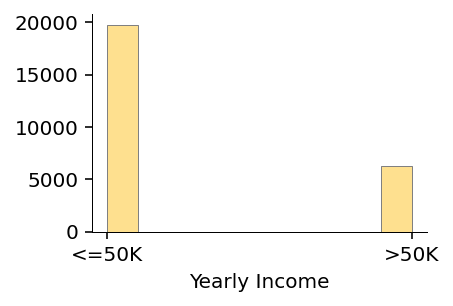

In [8]:
fig, ax = plt.subplots(figsize=(3,2))
histo(ax, X = data["yearly_income"])
ax.set_xlabel("Yearly Income")
plt.show()

From the correlation plot, we can see there're very little pairwise correlation between two features.

- Depends on the correlation plot we can tell row_id and fnl_wght has no predictive power so we can remove them when training the model

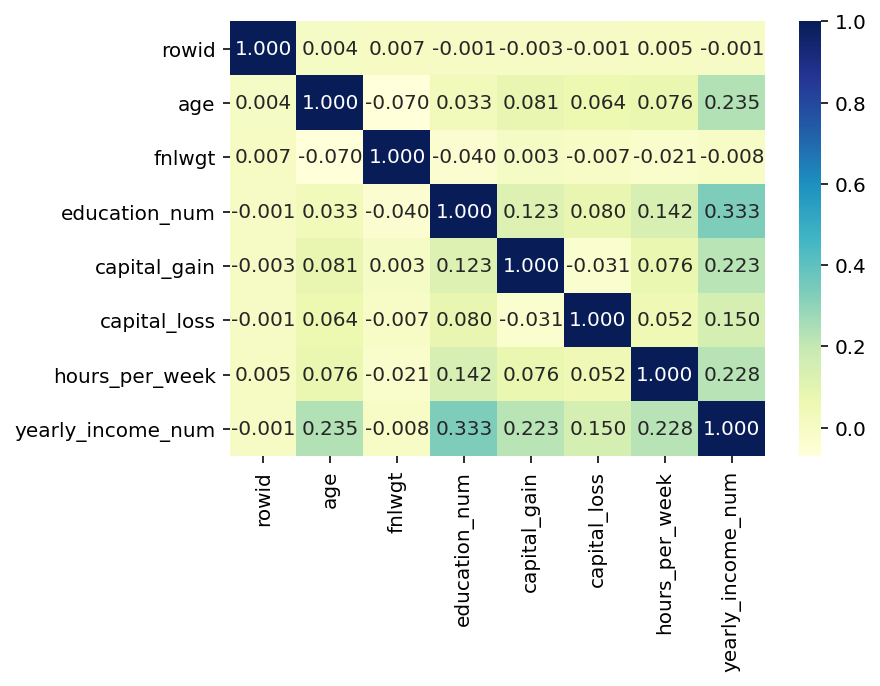

In [9]:
sns.heatmap(data.corr(), annot=True, fmt='.3f', cmap='YlGnBu');


## Explore Numerical value

Below, I plot all the distribution of numrical features

- for age distribution, it has a long tail distribution and makes sense since old people are rare 

- The distribution of finalweight seems to be rightly skewed 

- Majority of the Capital gain and loss are zeros 



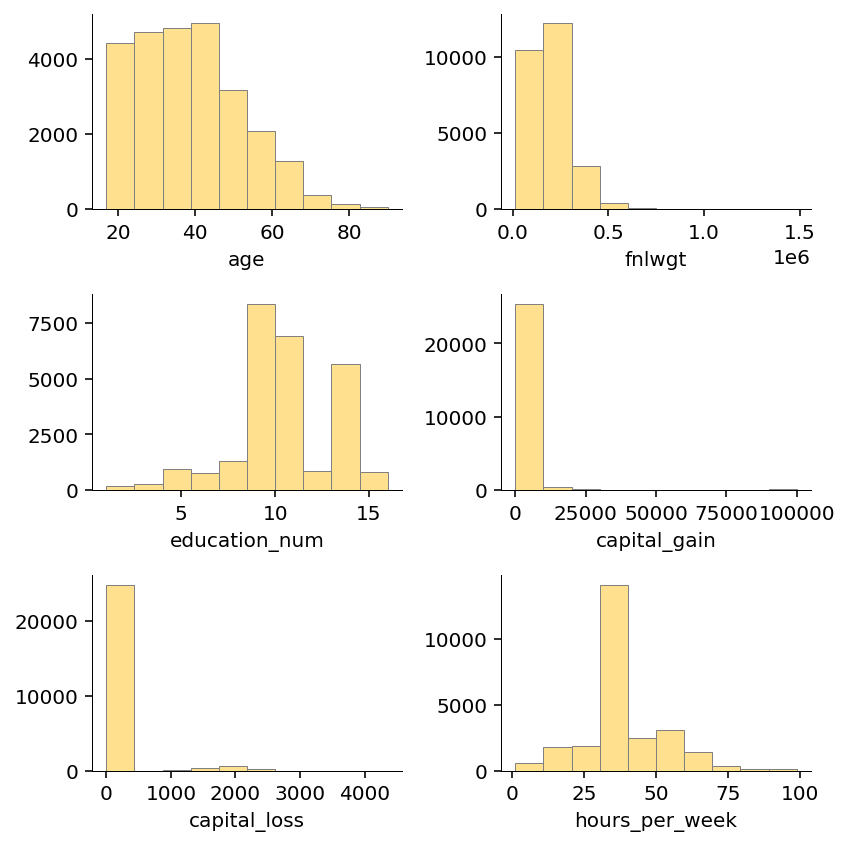

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 6))  # make one subplot (ax) on the figure
axes = axes.flatten() # it comes out as a 2D matrix; convert to a vector

for idx, col_name in enumerate(num_features):
	histo(axes[idx], data[col_name])
	axes[idx].set_xlabel(col_name)

plt.tight_layout() # I add this anytime I have a grid as it "does the right thing"
plt.show()

## Explore Categorical Value

- As we can tell below 23304 comes from United of stats and there're high cadinality with categorical feature

In [11]:
np.unique(data["native_country"], return_counts=True)

(array(['?', 'Cambodia', 'Canada', 'China', 'Columbia', 'Cuba',
        'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England',
        'France', 'Germany', 'Greece', 'Guatemala', 'Haiti',
        'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India',
        'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico',
        'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines',
        'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan',
        'Thailand', 'Trinadad&Tobago', 'United-States', 'Vietnam',
        'Yugoslavia'], dtype=object),
 array([  486,    16,    98,    61,    50,    77,    52,    23,    87,
           81,    19,   113,    20,    49,    37,     1,    11,    14,
           11,    76,    31,    20,    61,    62,    53,    14,   515,
           28,    10,    21,   159,    47,    33,    84,    11,    71,
           43,    14,    17, 23304,    54,    15]))

# Section2: Question Answer


Generate the following tables:

a. Calculate for different age ranges:
- i. the mean of hours-per-week
- ii. the median of education level
- iii. Use bins of width 10 (i.e. ages 20-30, 30-40, etc.)


In [12]:
section2_data = raw[["hours_per_week", 'education_num', 'age']].copy()

# bin the age range
bins = [17, 20, 30, 40, 50, 60, 70, 80, 90]

section2_data['age_range'] = pd.cut(raw['age'], bins=bins)

max(section2_data['age']), min(section2_data['age']) # max age 90 and minium age 17

(90, 17)

### i. the mean of hours-per-week with group by age range

In [13]:
section2_data[['hours_per_week', 'age_range']].groupby('age_range').mean('hours_per_week')

,hours_per_week
age_range,
"(17, 20]",30.091367
"(20, 30]",39.415547
"(30, 40]",43.195963
"(40, 50]",43.467328
"(50, 60]",42.535995
"(60, 70]",35.075577
"(70, 80]",26.746356
"(80, 90]",27.740260


### ii. the the median of education level group by age range

In [14]:
section2_data[['education_num', 'age_range']].groupby('age_range').median('education_num')

,education_num
age_range,
"(17, 20]",9
"(20, 30]",10
"(30, 40]",10
"(40, 50]",10
"(50, 60]",9
"(60, 70]",9
"(70, 80]",9
"(80, 90]",9


## b. Calculate the median age for males and females by occupation

In [15]:
median_age_by_occupation(gender="Female", data=data)

,age
occupation,
?,29.0
Adm-clerical,35.0
Armed-Forces,NaN
Craft-repair,39.0
Exec-managerial,39.0
Farming-fishing,39.0
Handlers-cleaners,32.0
Machine-op-inspct,37.0
Other-service,33.0


In [16]:
median_age_by_occupation(gender="Male", data=data)

,age
occupation,
?,47.0
Adm-clerical,36.0
Armed-Forces,24.0
Craft-repair,38.0
Exec-managerial,43.0
Farming-fishing,40.0
Handlers-cleaners,29.0
Machine-op-inspct,36.0
Other-service,31.0


In [20]:
y_train = data["yearly_income_num"]
X_train = data.drop(["rowid", "fnlwgt", "yearly_income", "yearly_income_num"], axis = 1)

data.columns, X_train.columns, X_train.shape

(Index(['rowid', 'age', 'workclass', 'fnlwgt', 'education', 'education_num',
        'marital_status', 'occupation', 'relationship', 'race', 'sex',
        'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
        'yearly_income', 'yearly_income_num'],
       dtype='object'),
 Index(['age', 'workclass', 'education', 'education_num', 'marital_status',
        'occupation', 'relationship', 'race', 'sex', 'capital_gain',
        'capital_loss', 'hours_per_week', 'native_country'],
       dtype='object'),
 (26049, 13))

# Section 3: Building Model KNN



### a. Perform any data transformations you find important prior to modeling

In [56]:

# seperate categorical and numerical features based on domain knowlage
cate = [1, 2, 4, 5, 6, 7, 8, 12]
nume = [0, 3, 9, 10, 11] 


from sklearn.feature_extraction import FeatureHasher


con_pipe = Pipeline \
    ([
        ('sca', StandardScaler()),  # apply standardscaler to numeric features
        ('imputer', SimpleImputer(strategy='median')) # fill null value with median
    ])

cat_pipe = Pipeline \
    ([
        ('str'    , FunctionTransformer(lambda x:(x.astype(str)), validate=False)),  # transform integer categoricals in to string
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('onehot' , OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer([(
        'conti', con_pipe, nume), 
        ('cate', cat_pipe, cate)
    ])

pipe = Pipeline(steps = [('preprocessor', preprocessor), ('knn', KNeighborsClassifier())])

## b. Build your best classifier using the training data

In [58]:


knnCV = RandomizedSearchCV(
                    pipe, 
                    n_iter=15,
                    param_distributions = {
                        'knn__leaf_size' : np.arange(4,30), 
                        'knn__n_neighbors': np.arange(2,25)
                    },
                    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5),
                    verbose=50,
                    scoring='f1',
                    n_jobs=-1)

knnCV.fit(X_train, y_train)

Fitting 25 folds for each of 15 candidates, totalling 375 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('conti',
                                                                               Pipeline(steps=[('sca',
                                                                                                StandardScaler()),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               [0,
                                                                                3,
                                                                                9,
                                                    

- b. Build your best classifier using the training data (hyparameter tuning)

In [60]:

cv_results = pd.DataFrame(knnCV.cv_results_) \
	[['param_knn__n_neighbors','param_knn__leaf_size','mean_test_score','rank_test_score']] \
	.sort_values(by='rank_test_score')

cv_results

,param_knn__n_neighbors,param_knn__leaf_size,mean_test_score,rank_test_score
2,19,21,0.648030,1
8,19,16,0.648030,1
14,19,11,0.648030,1
3,13,26,0.645215,4
10,9,6,0.641121,5
5,20,22,0.636397,6
6,20,25,0.636397,6
1,18,26,0.634330,8
7,18,6,0.634330,8
4,16,29,0.632329,10


- b. Build your best classifier using the training data (hyparameter tuning)

In [68]:
bestModel = knnCV.best_estimator_

In [69]:
bestModel.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('conti',
                                                  Pipeline(steps=[('sca',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  [0, 3, 9, 10, 11]),
                                                 ('cate',
                                                  Pipeline(steps=[('str',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7ff931c94b80>)),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                  

In [81]:
test = pd.read_csv("./data/IncomePredictionTest.txt")
X_test = test.drop(["rowid", "fnlwgt", "yearly_income"], axis = 1)

In [78]:
bestModel.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

In [82]:
X_test.columns, X_train.columns

Index(['age', 'workclass', 'education', 'education_num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')

In [86]:
prediction = bestModel.predict(X_test)

- c. Evaluate/Interpret how well you expect your model to perform on
the testdata using whatever metrics you consider to be most
important

- d. Use your model to generate class predictions for each
observation in thetest data

- e. Comment on how the choice of KNN influences your
representation of thedata prior to modeling and your overall approach to this question


I am expect my KNN classfier not performing well since on the cross validation the best f1 score is 0.648030, since model does not perform well on training data (underfitting) there's no way it is able to perform well on the test data. Other thing we can try is to do more feature engineering, and like reduce the categories of some features, as well as try other models.

# Modify the test data

In [90]:
test["yearly_income"] = prediction
test.to_csv("test_by_YeTao.csv")